In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

import PIL
import tensorflow_datasets as tfds
import tqdm

# Reading the Foggy Cityscapes dataset.

In [2]:
opj = os.path.join
# add the path to the Foggy Cityscapes dataset here.
foggy_data_dir = "/cns/li-d/home/dbash/cityscapes_foggy_original/"
splits_dict = {"train": ["aachen",  "bremen", "darmstadt",   "erfurt",
                         "hanover",  "krefeld",  "strasbourg",  "tubingen",
                         "weimar", "bochum", "cologne",  "dusseldorf", "hamburg",
                         "jena", "monchengladbach", "stuttgart", "ulm", "zurich"],
                "val": ["frankfurt",  "lindau",  "munster"]}

In [3]:
builder = tfds.builder('cityscapes')
dset = builder.as_dataset(split='validation+train')

In [4]:
def fname_to_data(fname):
  """Returns the corresponding foggy image and segmentation mask."""
  fname_str = fname.numpy().decode('ascii')
  img_path = opj(foggy_data_dir, "data", "%s_leftImg8bit_foggy_beta_0.01.png" % fname_str)
  lbl_path = opj(foggy_data_dir, "gtFine", "%s_gtFine_color.png" % fname_str)
  img = tf.io.decode_image(tf.io.read_file(img_path))
  lbl = tf.io.decode_image(tf.io.read_file(lbl_path))
  return img, lbl

In [5]:
def original_to_foggy(fname, label):
  """returns the foggy example with the filename from the original dataset."""
  fname = fname.numpy().decode('ascii')
  city, v_id, f_id = fname.split("_")
  split = "train" if city in splits_dict["train"] else "val"
  fname_new = "%s_%s_%s_leftImg8bit_foggy_beta_0.02.png" % (city, v_id, f_id)
  img_path = opj(foggy_data_dir, "data", split, city, fname_new)
  img = tf.io.decode_image(tf.io.read_file(img_path))
  return img, label

def decomp_example(example):
  return example["image_id"], example["segmentation_label"]

In [6]:
dec_dset = dset.map(decomp_example)
foggy_data = dec_dset.map(lambda x, y: tf.py_function(original_to_foggy, [x, y], [tf.uint8, tf.uint8]))

In [7]:
img, lbl = next(iter(foggy_data))

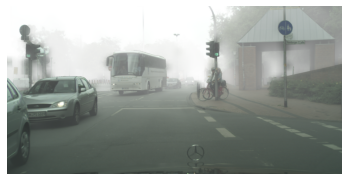

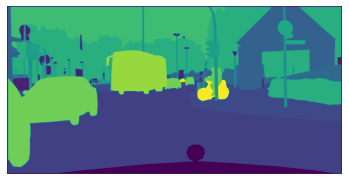

In [8]:
plt.imshow(img); plt.axis("off"); plt.show()
plt.imshow(lbl); plt.axis("off"); plt.show()

# Crop regions around pedestrians

In [16]:
def segm_to_binary(sample):
  """Maps multiclass segmentation mask to binary mask."""
  image, label = sample['image_left'], sample['segmentation_label']
  human_lbl = tf.cast(tf.equal(label, 24), tf.float32) + tf.cast(tf.equal(label, 25), tf.float32)
  return image, human_lbl

def segm_to_binary_with_mask(sample):
  """Maps multiclass segmentation mask to binary mask."""
  image, label = sample['image_left'], sample['segmentation_label']
  human_lbl = tf.cast(tf.equal(label, 24), tf.float32) + tf.cast(tf.equal(label, 25), tf.float32)
  return image, human_lbl, label


def segm_to_binary_foggy_with_mask(image, label):
  """Maps multiclass segmentation mask to binary mask."""
  human_lbl = tf.cast(tf.equal(label, 24), tf.float32) + tf.cast(tf.equal(label, 25), tf.float32)
  return image, human_lbl, label


def filter_by_human_area(image, label):
  human_area = tf.reduce_sum(label)
  return human_area > 25000

def filter_by_human_area_with_mask(image, label, mask):
  human_area = tf.reduce_sum(label)
  return human_area > 25000

def precess_merged_dataset(real_data, foggy_data):
  return (*real_data, foggy_data[0])

In [17]:
binary_dset = dset.map(segm_to_binary)
filtered_dataset = binary_dset.filter(filter_by_human_area)

In [10]:
binary_dset_w_mask = dset.map(segm_to_binary_with_mask)
bin_foggy_dset = foggy_data.map(segm_to_binary_foggy_with_mask)
merged_dset = tf.data.Dataset.zip((binary_dset_w_mask, bin_foggy_dset))
proc_merged_dset = merged_dset.map(precess_merged_dataset)

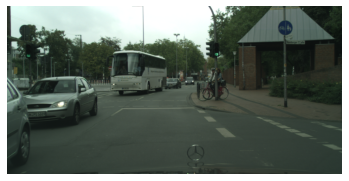

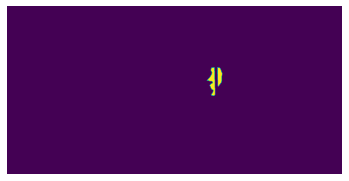

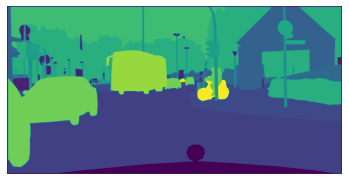

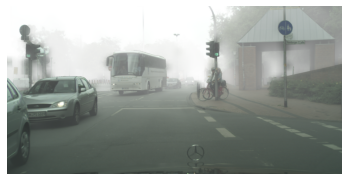

In [11]:
img, human_lbl, lbl, foggy_img = next(iter(proc_merged_dset))

for im in [img, human_lbl, lbl, foggy_img]:
  plt.imshow(im); plt.axis("off"); plt.show()

In [12]:
# we need to keep track of the sampled bounding boxes used for the data with
# pedestrians. We will sample from the same list of bboxes when we generate the
# data without pedestrians.
BBOX_LIST = []

In [15]:
# we can load a list of bboxes if we have one already.
with gfile.Open(opj("/path/to/bboxes/", "bboxes.npy"), "rb") as fin:
  BBOX_LIST = np.load(fin)

In [13]:
def random_crop_around_object(img, lbl, crop_size=(512, 512)):
  i = tf.constant(10)  # works
  j = 0
  while i > 0:
    topleft = tf.random.uniform((2,), minval=0., maxval=0.7)
    rightbottom = topleft + tf.random.uniform((2,), minval=0.25, maxval=0.5)
    rightbottom = tf.clip_by_value(rightbottom, 0., 1.)
    bbox = [tf.concat([topleft, rightbottom], axis=0)]
    cropped_lbl = tf.image.crop_and_resize(
        lbl, bbox, box_indices=tf.zeros([1,], dtype=tf.int32), 
        crop_size=crop_size)

    # only return the crops with sufficient human pixels
    if tf.reduce_sum(cropped_lbl) > 25000:
      break
    j += 1
    if j > 1000:
      return tf.zeros_like(img, tf.uint8), tf.zeros_like(lbl,  tf.uint8)
  cropped_img = tf.image.crop_and_resize(
          img, bbox, box_indices=tf.zeros([1,], dtype=tf.int32), 
          crop_size=crop_size)
  BBOX_LIST.append(bbox[0].numpy())
  return tf.cast(cropped_img[0], tf.uint8),  tf.cast(cropped_lbl[0], tf.uint8)


def bbox_crop_around_object_class_variety_merged(img, lbl, segm, foggy_img, crop_size=(512, 512)):
  i = tf.constant(10)  # works
  n_boxes = tf.constant(len(BBOX_LIST), tf.int32)
  j = 0
  while i > 0:
    idx = tf.random.uniform([], minval=0, maxval=n_boxes, dtype=tf.int32)
    bbox = [BBOX_LIST[idx]]
    cropped_lbl = tf.image.crop_and_resize(
        lbl, bbox, box_indices=tf.zeros([1,], dtype=tf.int32), 
        crop_size=crop_size)
    mask_flat = tf.reshape(segm, [-1])
    if tf.reduce_sum(cropped_lbl) == 0 and len(tf.unique(mask_flat)) > 1:
      break
    j += 1
    if j >= n_boxes:
      return [tf.zeros_like(img), tf.zeros_like(img)]
  cropped_img = tf.image.crop_and_resize(
        img, bbox, box_indices=tf.zeros([1,], dtype=tf.int32), 
        crop_size=crop_size)
  cropped_foggy_img = tf.image.crop_and_resize(
        foggy_img, bbox, box_indices=tf.zeros([1,], dtype=tf.int32), 
        crop_size=crop_size)
  return tf.cast(cropped_img[0], tf.uint8), tf.cast(cropped_foggy_img[0],  tf.uint8)

In [18]:
# creating a dataset with pedestrians.
cropped_dset = filtered_dataset.repeat(3).batch(1).map(lambda x, y: tf.py_function(random_crop_around_object, [x, y, ], [tf.uint8, tf.uint8]))
filtered_cropped_dset =  cropped_dset.filter(lambda x, y: tf.greater(tf.reduce_sum(x), 0))

In [19]:
print(len([0 for x in filtered_cropped_dset]))

2609


In [ ]:
out_fpath = "/path/to/bboxes/"
os.makedirs(out_fpath, exist_ok=True)

In [21]:
# out_dataset_path = "/cns/li-d/home/dbash/rs=6.3/synthetic-data/"
# saving the bboxes to file
with gfile.Open(opj(out_fpath, "test-bboxes.npy"), "wb") as fout:
    np.save(fout, np.array(BBOX_LIST))

In [ ]:
# see https://www.tensorflow.org/api_docs/python/tf/data/experimental/save
present_path = "/path/to/nonfoggy/present.tfrecord"
tf.data.experimental.save(filtered_cropped_dset, present_path)

In [19]:
# creating a datasets with and without the domain shift without pedestrians.
cropped_merged_dset = proc_merged_dset.repeat(2).batch(1).map(lambda x, y, z, t: tf.py_function(bbox_crop_around_object_class_variety_merged, [x, y, z, t, (512, 512)], [tf.uint8, tf.uint8]))
filtered_cropped_merged_dset =  cropped_merged_dset.filter(lambda x, y: tf.greater(tf.reduce_sum(x), 0))

In [30]:
filtered_cropped_merged_dset = filtered_cropped_merged_dset.cache("/tmp/merged_dset-2")
print(len([1 for x in filtered_cropped_merged_dset]))

6892


In [31]:
def get_real_img(img, foggy_img):
  return img


def get_foggy_img(img, foggy_img):
  return foggy_img

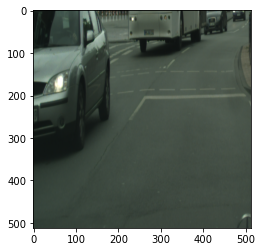

In [32]:
img_dset = filtered_cropped_merged_dset.map(get_real_img)
img = next(iter(img_dset))
plt.imshow(img); plt.show()

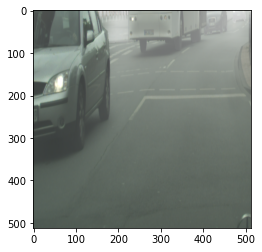

In [33]:
foggy_dset = filtered_cropped_merged_dset.map(get_foggy_img)
img = next(iter(foggy_dset))
plt.imshow(img); plt.show()

In [ ]:
nonfoggy_path = "/path/to/nonfoggy/absent.tfrecord"
tf.data.experimental.save(img_dset, nonfoggy_path)

6895it [14:10,  8.10it/s]


In [ ]:
foggy_path = "/path/to/foggy/absent.tfrecord"
tf.data.experimental.save(foggy_dset, foggy_path)